# t-SNE Visualization of Amazon Reviews

## [ CONTENTS ] 

01. About the dataset<br>
02. Objective<br>
03. Loading the data<br>
04. Exploratory Data Analysis<br>
    4.1 Data Cleaning: Duplication Removal<br>
    4.2 Data Cleaning: Entry Error Removal<br>
05. Text Preprocessing: Stemming, stop-word removal and Lemmatization<br>
06. Bag of Words(BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
07. TF-IDF<br>
08. Word2Vec<br>
09. Avg W2V, TFIDF-W2V<br>
10. Conclusion<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm considering the rating/score which is 4 or 5 as positive review and 1 or 2 as negative review. I'm ignoring the rating/score 3 considering it a neutral review. It is an approximate way to check polarity of a review. 

## 3. Loading the data
The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

In [1]:
#Importing required libraries 
import numpy as np 
import pandas as pd 
import matplotlib 
import seaborn as sns 
import sqlite3
import string
import nltk
import time
import warnings
from matplotlib import pyplot as plt
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

#Applying Truncated-SVD dimentional reduction technique 
def truncated_svd(data):
    svd = TruncatedSVD(n_components = 100, random_state = 0)
    svd_val = svd.fit_transform(data)
    return svd_val

#Applying t-sne and ploting in 2-D
def tsne_plot(data, perplex, name, size):
    model = TSNE(n_components=2, random_state=0, perplexity=perplex,  n_iter=1000)
    tsne_data = model.fit_transform(data)
    tsne_data = np.vstack((tsne_data.T, df_downsampled['Score'].iloc[:size])).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    
    sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.title('T-SNE Plot for '+ name, fontsize=12)
    plt.show()

In [3]:
#Establishing connection to the data
connect = sqlite3.connect('database.sqlite')

#Ignoring the rows which have rating 3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", connect)

#Denoting reviews positive(for rating > 3) or negative(for rating < 3) 
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#Preparing the filtered data
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
#Printing the shape & some rows of the dataset
print("The shape of filtered_data is :", filtered_data.shape)
filtered_data.head(5)

The shape of filtered_data is : (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 4. Exploratory Data Analysis  

### 4.1 Data Cleaning: Duplication Removal 
Sometimes Amazon sellers use a customer's single review for their multiple similar products, which may lead to biased results and redundancy in dataset.  

In [5]:
#checking of such redundant entries 
pd.read_sql_query('''
SELECT UserId, ProductId, Time, Text
FROM Reviews
WHERE UserId IN (
    SELECT UserId
    FROM Reviews
    GROUP BY UserId, Time
    HAVING COUNT(*) > 1)
    ORDER BY UserId ASC
''',connect).head(5)

,UserId,ProductId,Time,Text
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,1331510400,Overall its just OK when considering the price...
1,#oc-R115TNMSPFT9I7,B007Y59HVM,1331510400,Overall its just OK when considering the price...
2,#oc-R11D9D7SHXIJB9,B005HG9ESG,1342396800,"My wife has recurring extreme muscle spasms, u..."
3,#oc-R11D9D7SHXIJB9,B005HG9ERW,1342396800,"My wife has recurring extreme muscle spasms, u..."
4,#oc-R11D9D7SHXIJB9,B005HG9ET0,1342396800,"My wife has recurring extreme muscle spasms, u..."


#### Observation:
* Here the dataset is grouped by UserId and Time stamp. As no user can able to leave a review at same time for different products.
* But I found out that there are so many entries like UserId #oc-R115TNMSPFT9I7 with time stamp 1331510400 which has same reviews for multiple products with ProductId B005ZBZLT4 & B007Y59HVM.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Dropping the duplicates 
final_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data.shape

(364173, 10)

### 4.2 Data Cleaning: Entry Error Removal
HelpfulnessNumerator is always smaller than HelpfulnessDenominator. So I need to remove those entries to clean erroneous rows if any. 

In [8]:
#Querying to find these logical errors
pd.read_sql_query('''
SELECT Id, UserId, HelpfulnessNumerator, HelpfulnessDenominator
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY Id ASC
''',connect)

,Id,UserId,HelpfulnessNumerator,HelpfulnessDenominator
0,44737,A2V0I904FH7ABY,3,2
1,64422,A161DK06JJMCYF,3,1


#### Observation:
* I got 2 rows with Id 44737 & 64422 which have HelpfulnessNumerator greater than HelpfulnessDenominator.(which is impossibe logically)

In [9]:
#Removing above logical errors 
final_data = final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

#Printing the shape
print("Now final_data is of shape:", final_data.shape)

#Positive and negative class ratio
final_data['Score'].value_counts()

Now final_data is of shape: (364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 5. Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Textual data requires some preprocessing before applying any text-to-vector convertion algorithms to remove unnecessary words and special symbols etc.

Hence in the Preprocessing phase I will do the following text preprocessing in the order below:-

* Begin by removing the html tags
* Remove any punctuations or limited set of special characters like , or . or # etc.
* Check if the word is made up of english letters and is not alpha-numeric
* Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
* Convert the word to lowercase
* Remove Stopwords
* Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [10]:
#Importing required text preprocessing libraries 
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#Listing the stop words in English by nltk package
stop = set(stopwords.words('english'))
#Removing the word 'not' from the stopping words
stop.remove('not')
#Loading the snowball stammer for english 
sno = nltk.stem.SnowballStemmer('english') 

#Cleaning HTML tags from texts 
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
#Implementing mentioned steps in the text preprocessing phase
i = 0
str1 = ' '
final_string = []
all_positive_words = [] # store words from +ve reviews 
all_negative_words = [] # store words from -ve reviews 
s = ''

#Iterating over all textual data
for sentence in final_data['Text'].values:
    filtered_sentence = []
    #Removing HTMl tags
    sentence = cleanhtml(sentence) 
    for word in sentence.split():
        for cleaned_words in cleanpunc(word).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):    
                if(cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence)    
    final_string.append(str1)
    i+=1

In [12]:
#Adding a column of CleanedText which displays the data after pre-processing of the review 
final_data['CleanedText']=final_string 

In [13]:
#Storing final table into an SQlLite table for future usage.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

## 6. Bag of Words(BoW)
Bag of Words is a very simple algorithm to convert texts to vectors.
* It counts number of unique words in the whole corpus and assigns counts-dimentional vector to each texts, filling each feature(unique word) with number of repeated word(corresponding word).
* Output of Bow is generally a sparse matrix(Scipy.sparse.csr_matrix).

In [14]:
from sklearn.utils import resample

df_majority = final_data[final_data.Score=='positive']
df_minority = final_data[final_data.Score=='negative']
 
#Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,       #sample without replacement
                                 n_samples=57110,     #to match minority class
                                 random_state=1)      #reproducible results
 
#Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [15]:
#sorting the data according to time-stamp
df_downsampled = df_downsampled.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [16]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(df_downsampled['CleanedText'].values)

In [17]:
final_counts.shape

(114220, 41258)

In [18]:
#Applying standardization and Truncated-SVD
stnd_bow = standardizer(final_counts)
svd_bow = truncated_svd(stnd_bow)
svd_bow.shape

(114220, 100)

### t-SNE plot for Bag of Words (BoW)

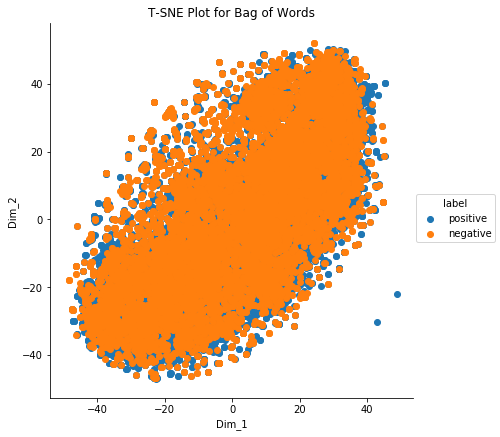

In [19]:
tsne_plot(svd_bow[:20000], 70, 'Bag of Words', 20000)

#### Observation:
* As we can see that both classes are completely overlapped and t-sne is not able to separate them on 2-D plane.
* So, the bag of words technique seems lacking in separating both the classes. 

### 6.1 Bi-Grams & N-Grams

Bag of Words results in unigrams. But sometimes it is better to use bi-grams or n-grams to retrive more meaningful words. For that reason I have removed the word 'not' from stopping words as the word 'not' can add more meaning when we use bi-grams.   

In [20]:
#Finding most frequency dist. of words 
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)

#Printing top 20 frequently used words
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'not', 146797), (b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715)]
Most Common Negative Words :  [(b'not', 54378), (b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073)]


#### Observation: 
As you can see we have a lot of words in common which does not make senses. The word like appears in both positive and negative reviews. But, It can be possible that the user would have typed 'not like' in the negative review. So It seems better to add bi-grams to our bag of words list. 

In [21]:
#Adding both uni-gram and bi-gram to BoW
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(df_downsampled['CleanedText'].values)

In [22]:
final_bigram_counts.shape

(114220, 1428081)

#### Observation:
As the n increases in n-gram the number of unique words increases drastically. So, the dimension of each review has increased to ~ 291K 

In [23]:
stnd_bi_bow = standardizer(final_bigram_counts)
svd_bi_bow = truncated_svd(stnd_bi_bow)
svd_bi_bow.shape

(114220, 100)

### t-SNE plot for Bag of Words (Bigram)

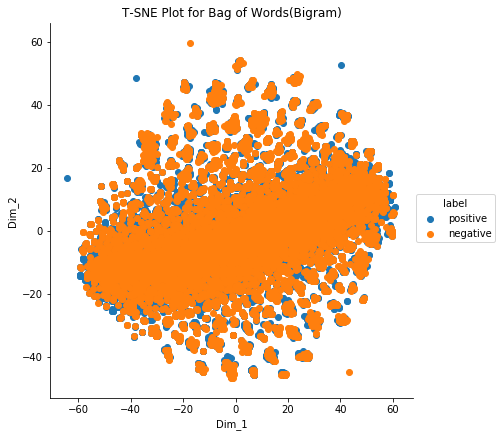

In [24]:
tsne_plot(svd_bi_bow[:20000], 80, 'Bag of Words(Bigram)', 20000)

#### Observation:
* From this t-sne plot it seems like some reviews form some kind of clusters. But again both classes clusters overlap with each other. So, bigram is also not helping us here to separate both classes. 

## 7. TF-IDF
In tf-idf it gives weightage to rare words in the corpus.

In [16]:
#Applying tf-idf to cleaned text
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(df_downsampled['CleanedText'].values)

In [17]:
print(final_tf_idf.shape)
type(final_tf_idf)

(114220, 1428081)


scipy.sparse.csr.csr_matrix

In [18]:
#Finding such rare words in this corpus along with its tf-idf value
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],tf_idf_vect.get_feature_names(),10)
print(top_tfidf)

         feature     tfidf
0           movi  0.330025
1  action whatev  0.286911
2  comedi action  0.286911
3   movi collect  0.286911
4    fill comedi  0.286911
5      movi movi  0.277178
6   collect fill  0.270273
7       one movi  0.270273
8      want call  0.240202
9         comedi  0.238545


In [19]:
#Applying standardization and Truncated-SVD
stnd_tf_idf = standardizer(final_tf_idf)
svd_tf_idf = truncated_svd(stnd_tf_idf)
svd_tf_idf.shape

(114220, 100)

### t-SNE plot for TF-IDF

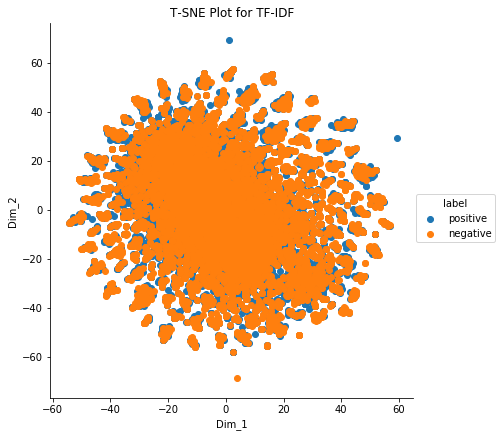

In [20]:
tsne_plot(svd_tf_idf[:20000], 90, 'TF-IDF', 20000)

#### Observation:
* We are getting similar results like the bigram one. And it is not helpful.

## 8. Word2Vec
It converts word to a dense vector. It preserves semantic meaning along with other relationships like tense, gender etc. 

In [20]:
#Importing required library
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#Loading pre-trained model by google
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [22]:
model.wv['coding'].shape

(300,)

Word2Vec returns a vector in the form of numpy.array and it is a 300-dimentional dense vector.

In [23]:
#Checking similarity between 2 words 
model.wv.similarity('malware', 'antivirus')

0.7473245295423512

The similarity between 'malware' and 'antivirus' is 0.7473245295423512, which is pretty much close.

In [21]:
#Again preprocessing the corpus without any stemming 
i = 0
list_of_sent = []
for sent in df_downsampled['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [22]:
print(df_downsampled['Text'].values[0])
print(list_of_sent[0])

Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetlejuice!
['beetlejuice', 'is', 'an', 'excellent', 'and', 'funny', 'movie', 'keaton', 'is', 'hilarious', 'as', 'the', 'wacky', 'beetlejuice', 'the', 'great', 'special', 'effects', 'help', 'the', 'film', 'i', 'think', 'this', 'is', 'one', 'of', 'the', 'best', 'movies', 'ever', 'made', 'and', 'im', 'sure', 'youll', 'agree', 'for', 'a', 'good', 'time', 'watch', 'beetlejuice']


In [23]:
#Generating my own model on text corpus
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [24]:
#Counting total words in my model 
words = list(w2v_model.wv.vocab)
print(len(words))

20878


In [25]:
#Printing the dimention of each word
w2v_model.wv['book'].size

100

## 9. Avg W2V, TFIDF-W2V
These are 2 different methods to form vectors from sentences(text reviews).

In [61]:
#Determining average Word2Vec for each review
sent_vectors = []
for sent in list_of_sent: 
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

114220
100


In [62]:
avg_word2vec = np.matrix(sent_vectors)

In [63]:
#Applying standardization 
stnd_avg_word2vec = standardizer(avg_word2vec)
stnd_avg_word2vec.shape

(114220, 100)

### t-SNE plot for Avg-Word2Vec

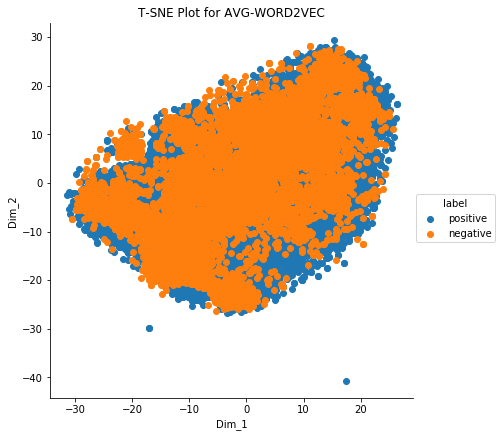

In [51]:
tsne_plot(stnd_avg_word2vec[:20000], 120, 'AVG-WORD2VEC', 20000)

#### Observation:
* Here all the negative data points are grouped closedly than that of positive points. Still they overlap significantly that it is impossible to separate both of the classes.

In [36]:
# Determining TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors = []
row = 0
tic = time.time()
for sent in list_of_sent[:10000]: 
    sent_vec = np.zeros(100)
    weight_sum = 0 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
toc = time.time()
print(toc - tic)

50357.852523088455


In [37]:
tfidf_word2vec = np.matrix(tfidf_sent_vectors)

In [38]:
tfidf_word2vec.shape

(10000, 100)

In [48]:
where_are_NaNs = np.isnan(tfidf_word2vec)
tfidf_word2vec[where_are_NaNs] = 0

In [49]:
np.any(np.isnan(tfidf_word2vec))

False

### t-SNE plot for TFIDF-Word2Vec

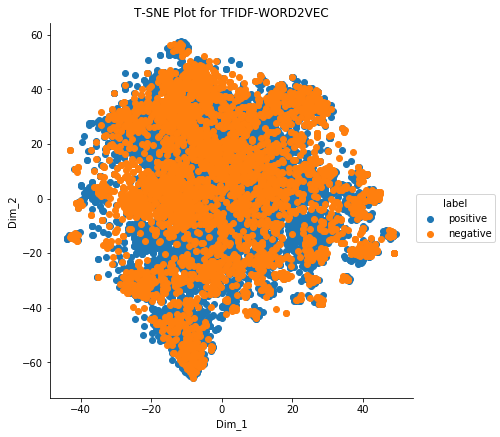

In [50]:
tsne_plot(tfidf_word2vec, 70, 'TFIDF-WORD2VEC', 10000)

#### Observation:
* Mostly similar to the avg-word2vec. All data points from different classes overlap which is not helpful. 

## 10. Conclusion:
* All above four methods of text to feature conversion don't help t-SNE to separate both classes in 2-Dimention.
* But, it does not mean that both classes are inseparable. t-SNE is an approximation algorithm so there may be a chance that both the classes are linearly separable in high dimentional space and it is not possible for t-SNE to show that in 2-D plane.